In [1]:
import os
import numpy as np
import nibabel as nib
from tqdm import tqdm
import pandas as pd
import torch
import torchio as tio
import matplotlib.pyplot as plt
from dataset_tio import SimImage, MRBrainS18Image, HCPImage, OASISImage, calculate_overlap, sim_data, \
    MRBrainS18_data, HCP_data, OASIS_data, perc_norm
from glob import glob
from metrics import NCC
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import normalized_root_mse as NRMSE
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import cv2
import copy

print(os.getcwd())

/mnt/beta/djboonstoppel/Code


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
root_dir = '/mnt/beta/djboonstoppel/Code'
data_path = os.path.join(root_dir, 'data')
middle_slices = None
every_other = 1
source = 'hcp'
std = 0.3548

In [4]:
if source == 'sim':
    val_subjects, subjects_info = sim_data(dataset='validation',
                            root_dir=data_path,
                            middle_slices=middle_slices,
                            every_other=every_other)
elif source == 'hcp':
    val_subjects, subjects_info = HCP_data(dataset='validation',
                            root_dir=data_path,
                            middle_slices=middle_slices,
                            every_other=every_other)
    fname = '_3T_T1w_MPR1_img_SR_'
elif source == 'oasis':
    val_subjects, subjects_info = OASIS_data(dataset='validation',
                              root_dir=data_path,
                              middle_slices=middle_slices,
                              every_other=every_other)
elif source == 'mrbrains':
    val_subjects, subjects_info = MRBrainS18_data(dataset='validation',
                                   root_dir=data_path,
                                   middle_slices=middle_slices,
                                   every_other=every_other)
else:
    raise ValueError("Dataset '{}' not implemented".format(source))

Loading HCP validation set...


In [5]:
nr_hcp_train = [1,5,20]
nr_sim_train = [1,5,20]#,5,10,20,30,50]

In [6]:
for i in tqdm(range(len(val_subjects))):
    subject = val_subjects[i]
    for nr_hcp in nr_hcp_train:
        for nr_sim in nr_sim_train:
            folder = 'hcp{:02d}_sim{:02d}'.format(nr_hcp, nr_sim)
            SR_path = os.path.join(root_dir, 'output', 'sweep-2', source, folder, 'SR')

            _fname = '{:06d}'.format(subjects_info[i]['id'])+fname+'hcp{:02d}_sim{:02d}.nii.gz'.format(nr_hcp, nr_sim)
            os.path.join(SR_path, _fname)
            SR = nib.load(os.path.join(SR_path, _fname))
            SR_norm, _ = perc_norm(SR.get_fdata())
            subject.add_image(tio.ScalarImage(tensor=torch.from_numpy(np.expand_dims(SR_norm, 0))), 'SR_{}_{}'.format(nr_hcp, nr_sim))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:18<00:00,  7.87s/it]


In [7]:
def post_proc(img:torch.Tensor, bg_idx:np.ndarray, crop_coords:tuple) -> np.ndarray:
    img_np = copy.deepcopy(img)
    img_np = img_np.data.squeeze().numpy()
    img_np[bg_idx] = 0
    # nonzero_mean = img_np[np.nonzero(img_np)].mean()
    # img_np -= nonzero_mean
    # img_np[bg_idx] = 0
    min, max = crop_coords
    img_np = img_np[min[0]:max[0]+1, min[1]:max[1]+1, min[2]:max[2]+1]#.numpy()#*std
    return img_np

In [ ]:
# df = pd.DataFrame(columns = nr_hcp_train, index = nr_sim_train)
# df = df.apply(lambda s: s.fillna({i: [] for i in df.index}))
#
# ssim_df = df.copy(deep=True)
# ncc_df = df.copy(deep=True)
# nrmse_df = df.copy(deep=True)

ssim_df = pd.DataFrame(columns = nr_hcp_train, index = nr_sim_train)
ssim_df = ssim_df.apply(lambda s: s.fillna({i: [] for i in ssim_df.index}))

ncc_df = pd.DataFrame(columns = nr_hcp_train, index = nr_sim_train)
ncc_df = ncc_df.apply(lambda s: s.fillna({i: [] for i in ncc_df.index}))

nrmse_df = pd.DataFrame(columns = nr_hcp_train, index = nr_sim_train)
nrmse_df = nrmse_df.apply(lambda s: s.fillna({i: [] for i in nrmse_df.index}))

for i in tqdm(range(len(val_subjects))):
    subject = val_subjects[i]
    mask = subject['MSK'].data.squeeze()
    bg_idx = np.where(mask==0)
    brain_idx = np.where(mask!=0)
    crop_coords = ([brain_idx[i].min() for i in range(len(brain_idx))],
                   [brain_idx[i].max() for i in range(len(brain_idx))])
    HR = post_proc(subject['HR'],
                   bg_idx=bg_idx,
                   crop_coords=crop_coords)
    for nr_hcp in nr_hcp_train:
        for nr_sim in nr_sim_train:
            SR = post_proc(img=subject['SR_{}_{}'.format(nr_hcp, nr_sim)],
                           bg_idx=bg_idx,
                           crop_coords=crop_coords)
            ssim_df[nr_hcp][nr_sim].append(SSIM(HR, SR, gaussian_weights=True, sigma=1.5, use_sample_covariance=False))
            ncc_df[nr_hcp][nr_sim].append(NCC(HR, SR))
            nrmse_df[nr_hcp][nr_sim].append(NRMSE(HR, SR))

In [ ]:
# ssim_df.to_csv('ssim_df.csv')
# ncc_df.to_csv('ncc_df.csv')
# nrmse_df.to_csv('nrmse_df.csv')

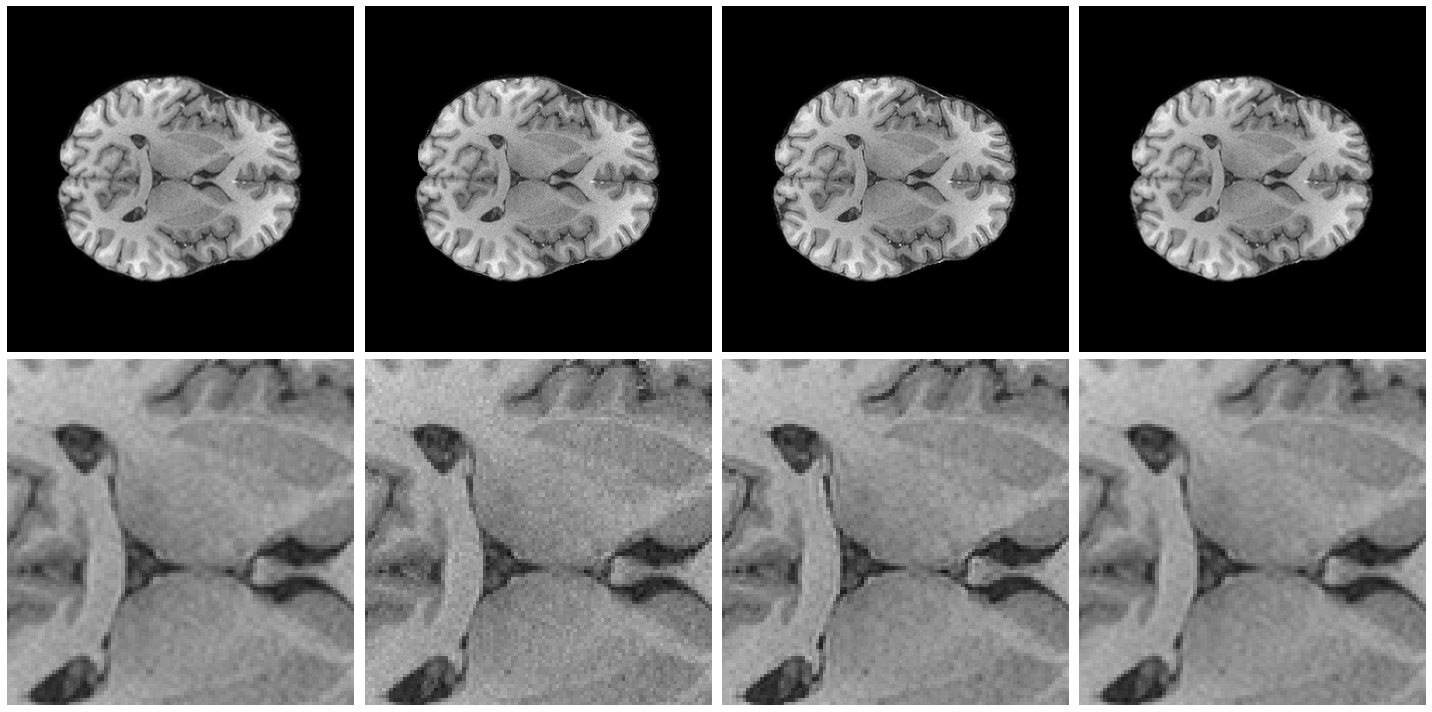

In [8]:
subject = val_subjects[0]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.set_facecolor('white')
for axis in axes:
    for xs in axis:
        xs.set_axis_off()
axes[0,0].imshow(subject['LR'][tio.DATA][0,:,:,100], cmap='gray', vmin=0, vmax=1.5)
axes[1,0].imshow(subject['LR'][tio.DATA][0,100:200,100:200,100], cmap='gray', vmin=0, vmax=1.5)
axes[0,1].imshow(subject['HR'][tio.DATA][0,:,:,100], cmap='gray', vmin=0, vmax=1.5)
axes[1,1].imshow(subject['HR'][tio.DATA][0,100:200,100:200,100], cmap='gray', vmin=0, vmax=1.5)
axes[0,2].imshow(subject['SR_1_20'][tio.DATA][0,:,:,100], cmap='gray', vmin=0, vmax=1.5)
axes[1,2].imshow(subject['SR_1_20'][tio.DATA][0,100:200,100:200,100], cmap='gray', vmin=0, vmax=1.5)
axes[0,3].imshow(subject['SR_1_1'][tio.DATA][0,:,:,100], cmap='gray', vmin=0, vmax=1.5)
axes[1,3].imshow(subject['SR_1_1'][tio.DATA][0,100:200,100:200,100], cmap='gray', vmin=0, vmax=1.5)
plt.tight_layout()
plt.show()

In [12]:
mask = subject['MSK'].data.squeeze()
bg_idx = np.where(mask==0)
brain_idx = np.where(mask!=0)
crop_coords = ([brain_idx[i].min() for i in range(len(brain_idx))],
               [brain_idx[i].max() for i in range(len(brain_idx))])
HR = post_proc(subject['HR'],
               bg_idx=bg_idx,
               crop_coords=crop_coords)

nr_hcp = 1
nr_sim = 1
SR = post_proc(img=subject['SR_{}_{}'.format(nr_hcp, nr_sim)],
               bg_idx=bg_idx,
               crop_coords=crop_coords)

LR = post_proc(img=subject['LR'.format(nr_hcp, nr_sim)],
               bg_idx=bg_idx,
               crop_coords=crop_coords)
# LR = (LR*10**10).astype(int)
# HR = (HR*10**10).astype(int)
# SR = (SR*10**10).astype(int)
# print(np.max(LR))
# print(LR[0,0,0])

0.9693879430996771
0.9693879430996771 0.9693879430996771
0.6366253278209139 1.0
0.0 2.5061199510403918


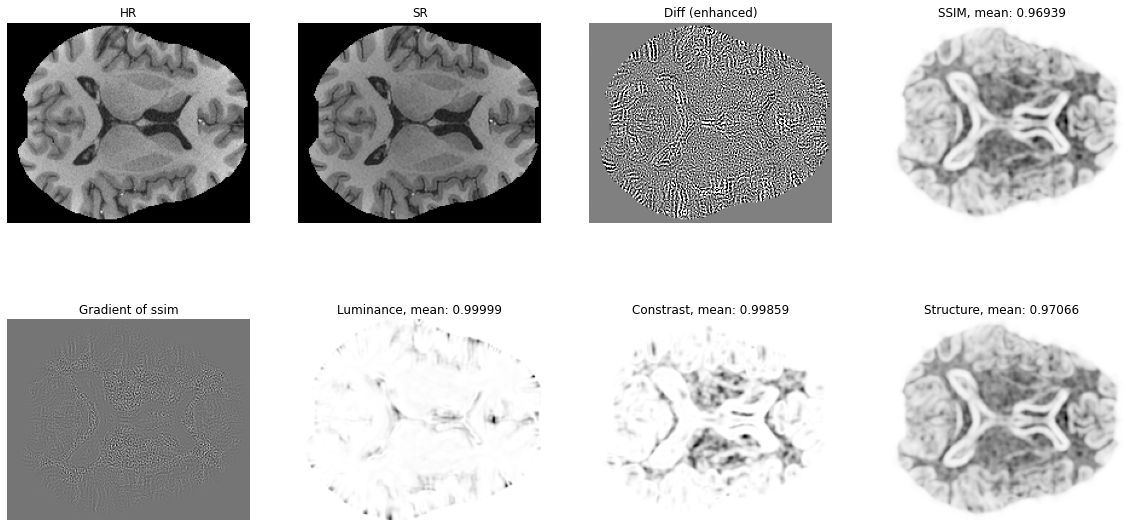

In [46]:
from skimage.metrics import structural_similarity as SSIM
from ssim_adapted import structural_similarity as ssim_adapted
from skimage.util.arraycrop import crop


print(SSIM(HR, SR, gaussian_weights=True, sigma=1.5, use_sample_covariance=False))
ssim, gradient, S, components = ssim_adapted(HR, SR, gaussian_weights=True, sigma=1.5, use_sample_covariance=False, full=True, gradient=True)
print(ssim, crop(S, 5).mean(dtype=np.float64))
print(np.min(S), np.max(S))
print(np.min(LR), np.max(HR))
l,c,s = components
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.set_facecolor('white')
for axis in axes:
    for xs in axis:
        xs.set_axis_off()
axes[0,0].imshow(HR[:,:,100], cmap='gray')
axes[0,0].set_title('HR')
axes[0,1].imshow(SR[:,:,100], cmap='gray')
axes[0,1].set_title('SR')
diff = (HR[:,:,100]-SR[:,:,100])
axes[0,2].imshow(diff, cmap='gray', vmin=-.05, vmax=.05)
axes[0,2].set_title('Diff (enhanced)')
axes[0,3].imshow(S[:,:,100], cmap='gray')
axes[0,3].set_title('SSIM, mean: {:.5f}'.format(crop(S, 5).mean(dtype=np.float64)))
axes[1,0].imshow(gradient[:,:,100], cmap='gray')
axes[1,0].set_title('Gradient of ssim')
axes[1,1].imshow(l[:,:,100], cmap='gray')
axes[1,1].set_title('Luminance, mean: {:.5f}'.format(crop(l, 5).mean(dtype=np.float64)))
axes[1,2].imshow(c[:,:,100], cmap='gray')
axes[1,2].set_title('Constrast, mean: {:.5f}'.format(crop(c, 5).mean(dtype=np.float64)))
axes[1,3].imshow(s[:,:,100], cmap='gray')
axes[1,3].set_title('Structure, mean: {:.5f}'.format(crop(s, 5).mean(dtype=np.float64)))
name = 'SSIM_plot'
fig.savefig(os.path.join('figs', name+'.png'), dpi=300, bbox_inches='tight')

In [18]:
def weighted_percentile(error_map, percentile):
	"""
	Computes a weighted percentile of an error map, i.e., the error which is such that the sum of
	the errors in the error map that are smaller than it and those that are larger than it
	are `percentile` percent of total error sum and `100 - percentile` percent of the total error sum, respectively.
	For example, if percentile = 50, the weighted percentile is the error satisfying that the errors in the
	error map that are smaller than it is 50% of the total error sum, and similar for the errors that are larger than it.
	:param error_map: matrix (with HxW layout) containing per-pixel FLIP values in the [0,1] range
	:param percentile: integer in the [0, 100] range describing which percentile is sought
	:return: float containing the weighted percentile
	"""
	error_sum = np.sum(error_map)
	percentile_equilibrium = error_sum * percentile / 100
	error_sorted = np.sort(error_map, axis=None)
	weighted_percentile_index = np.cumsum(error_sorted).searchsorted(percentile_equilibrium)
	weighted_percentile_error = 0.5 * (error_sorted[weighted_percentile_index + 1] + error_sorted[weighted_percentile_index])

	return weighted_percentile_error

In [55]:
from flip_api import compute_ldrflip as flip

def calc_error_map(reference, test):
    monitor_distance = 1
    monitor_resolution_x = 1920
    monitor_width = 0.4
    pixels_per_degree = monitor_distance * (monitor_resolution_x / monitor_width) * (np.pi / 180)
    # pixels_per_degree = (0.7 * 3840 / 0.7) * np.pi / 180
    # print(pixels_per_degree)
    preprocessed_reference, reference_y, error_map, color, features = flip(reference, test, pixels_per_degree)

    mean = "%.6f" % np.mean(error_map)
    weighted_median = "%.6f" % weighted_percentile(error_map, 50)
    weighted_quartile1 = "%.6f" % weighted_percentile(error_map, 25)
    weighted_quartile3 = "%.6f" % weighted_percentile(error_map, 75)
    minimum = "%.6f" % np.amin(error_map)
    maximum = "%.6f" % np.amax(error_map)

    mean_c = "%.6f" % np.mean(color)
    weighted_median_c = "%.6f" % weighted_percentile(color, 50)
    weighted_quartile1_c = "%.6f" % weighted_percentile(color, 25)
    weighted_quartile3_c = "%.6f" % weighted_percentile(color, 75)
    minimum_c = "%.6f" % np.amin(color)
    maximum_c = "%.6f" % np.amax(color)

    mean_f = "%.6f" % np.mean(features)
    weighted_median_f = "%.6f" % weighted_percentile(features, 50)
    weighted_quartile1_f = "%.6f" % weighted_percentile(features, 25)
    weighted_quartile3_f = "%.6f" % weighted_percentile(features, 75)
    minimum_f = "%.6f" % np.amin(features)
    maximum_f = "%.6f" % np.amax(features)

    print("Metric\t\t\tFlip\t\tcolor\t\tfeature")
    print("Mean: \t\t\t{}\t{}\t{}".format(mean, mean_c, mean_f))
    print("Weighted median: \t{}\t{}\t{}".format(weighted_median, weighted_median_c, weighted_median_f))
    print("1st weighted quartile: \t{}\t{}\t{}".format(weighted_quartile1, weighted_quartile1_c, weighted_quartile1_f))
    print("3rd weighted quartile: \t{}\t{}\t{}".format(weighted_quartile3, weighted_quartile3_c, weighted_quartile3_f))
    print("Min: \t\t\t{}\t{}\t{}".format(minimum, minimum_c, minimum_f))
    print("Max: \t\t\t{}\t{}\t{}".format(maximum, maximum_c, maximum_f))
    return preprocessed_reference, reference_y, error_map, color, features

In [56]:
nr_hcp = 1
nr_sim = 20
SR = post_proc(img=subject['SR_{}_{}'.format(nr_hcp, nr_sim)],
               bg_idx=bg_idx,
               crop_coords=crop_coords)

reference = np.repeat(np.expand_dims(HR[:,:,100],0), 3, 0)
test = np.repeat(np.expand_dims(SR[:,:,100],0), 3, 0)
print('HR - SR')
preprocessed_reference, reference_y, error_map, color, features = calc_error_map(reference, test)

HR - SR
Metric			Flip		color		feature
Mean: 			0.018218	0.014857	0.045132
Weighted median: 	0.034554	0.028677	0.060952
1st weighted quartile: 	0.024830	0.020495	0.047249
3rd weighted quartile: 	0.048536	0.039767	0.074615
Min: 			0.000000	0.000000	0.000000
Max: 			0.223907	0.174998	0.168787


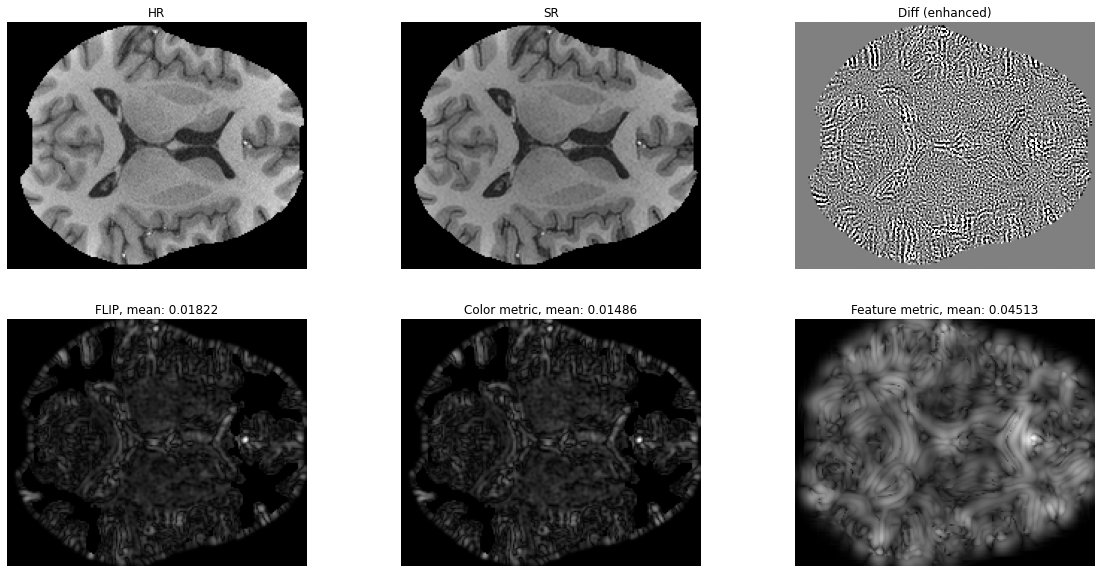

In [57]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
fig.set_facecolor('white')
for axis in axes:
    for xs in axis:
        xs.set_axis_off()
axes[0,0].imshow(HR[:,:,100], cmap='gray')
axes[0,0].set_title('HR')
axes[0,1].imshow(SR[:,:,100], cmap='gray')
axes[0,1].set_title('SR')
diff = (HR[:,:,100]-SR[:,:,100])
axes[0,2].imshow(diff, cmap='gray', vmin=-.05, vmax=.05)
axes[0,2].set_title('Diff (enhanced)')
# axes[0,3].imshow(S[:,:,100], cmap='gray')
# axes[0,3].set_title('SSIM, mean: {:.5f}'.format(crop(S, 5).mean(dtype=np.float64)))
axes[1,0].imshow(error_map[0], cmap='gray')
axes[1,0].set_title('FLIP, mean: {:.5f}'.format(np.mean(error_map)))
axes[1,1].imshow(color[0], cmap='gray')
axes[1,1].set_title('Color metric, mean: {:.5f}'.format(np.mean(color)))
axes[1,2].imshow(features, cmap='gray')
axes[1,2].set_title('Feature metric, mean: {:.5f}'.format(np.mean(features)))
# axes[1,3].imshow(s[:,:,100], cmap='gray')
# axes[1,3].set_title('Structure, mean: {:.5f}'.format(crop(s, 5).mean(dtype=np.float64)))
name = 'FLIP_plot'
# fig.savefig(os.path.join('figs', name+'.png'), dpi=300, bbox_inches='tight')

In [22]:
reference = np.repeat(np.expand_dims(HR[:,:,100],0), 3, 0)
test = np.repeat(np.expand_dims(LR[:,:,100],0), 3, 0)
print('HR - LR')
preprocessed_reference, reference_y, error_map, color, features = calc_error_map(reference, test)

HR - LR
Metric			Flip		color		feature
Mean: 			0.009199	0.007838	0.028031
Weighted median: 	0.018708	0.016016	0.037683
1st weighted quartile: 	0.012040	0.010334	0.029310
3rd weighted quartile: 	0.032809	0.028074	0.046994
Min: 			0.000000	0.000000	0.000000
Max: 			0.170512	0.145161	0.131786


In [3]:
def convert(df, name, index):
    return [float(x) for x in (df[name][index].strip('[]')).split(", ")]

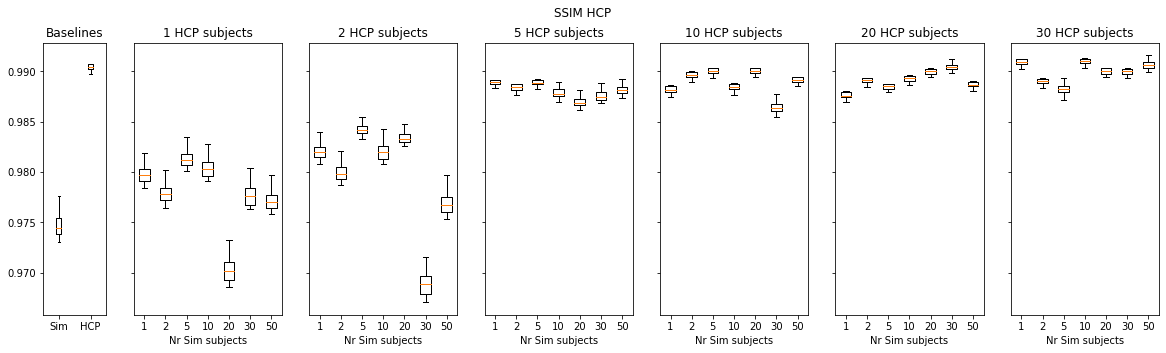

In [27]:
ssim_str1 = pd.read_csv('/mnt/beta/djboonstoppel/Code/output/baseline/hcp/ssim_df_baseline_hcp.csv', index_col=0, names=[30])
ssim_str2 = pd.read_csv('/mnt/beta/djboonstoppel/Code/output/baseline/hcp/ssim_df_baseline_sim.csv', index_col=0, names=[0])
baseline_hcp = [float(x) for x in (ssim_str1[30][0].strip('[]')).split(", ")]
baseline_sim = [float(x) for x in (ssim_str2[0][50].strip('[]')).split(", ")]
baselines = [baseline_sim, baseline_hcp]

ssim_str = pd.read_csv('/mnt/beta/djboonstoppel/Code/output/sweep-2/hcp/ssim_df.csv', index_col=0, names=[1,2,5,10,20,30])
nr_hcp_train = [1,2,5,10,20,30]
nr_sim_train = [1,2,5,10,20,30,50]
ssim = pd.DataFrame(columns = nr_hcp_train, index = nr_sim_train)
for nr_hcp in nr_hcp_train:
    for nr_sim in nr_sim_train:
        ssim[nr_hcp][nr_sim] = convert(ssim_str, nr_hcp, nr_sim)

# fig, ax = plt.subplots(nrows=1, ncols=len(nr_sim_train)+1, figsize=[20,5], sharey=True, gridspec_kw={'width_ratios': [3,6,6,6,6,6,6,6]})
# fig.set_facecolor('white')
# fig.suptitle('SSIM HCP')
# ax[0].boxplot(baselines, showfliers=False)
# ax[0].set_title('Baselines')
# ax[0].set_xticklabels(['Sim', 'HCP'])
# for i in range(len(nr_sim_train)):
#     ax[i+1].boxplot(ssim.loc[nr_sim_train[i]], showfliers=False)
#     ax[i+1].set_title('{} Sim subjects'.format(nr_sim_train[i]))
#     ax[i+1].set_xlabel('Nr HCP subjects')
#     ax[i+1].set_xticklabels(nr_hcp_train)
# fig.show()

fig, ax = plt.subplots(nrows=1, ncols=len(nr_hcp_train)+1, figsize=[20,5], sharey=True, gridspec_kw={'width_ratios': [3,7,7,7,7,7,7]})
fig.set_facecolor('white')
fig.suptitle('SSIM HCP')
ax[0].boxplot(baselines, showfliers=False)
ax[0].set_title('Baselines')
ax[0].set_xticklabels(['Sim', 'HCP'])
for i in range(len(nr_hcp_train)):
    ax[i+1].boxplot(ssim[nr_hcp_train[i]], showfliers=False)
    ax[i+1].set_title('{} HCP subjects'.format(nr_hcp_train[i]))
    ax[i+1].set_xlabel('Nr Sim subjects')
    ax[i+1].set_xticklabels(nr_sim_train)
fig.show()
name = 'SSIM'
fig.savefig(os.path.join('figs', name+'.png'), dpi=300, bbox_inches='tight')

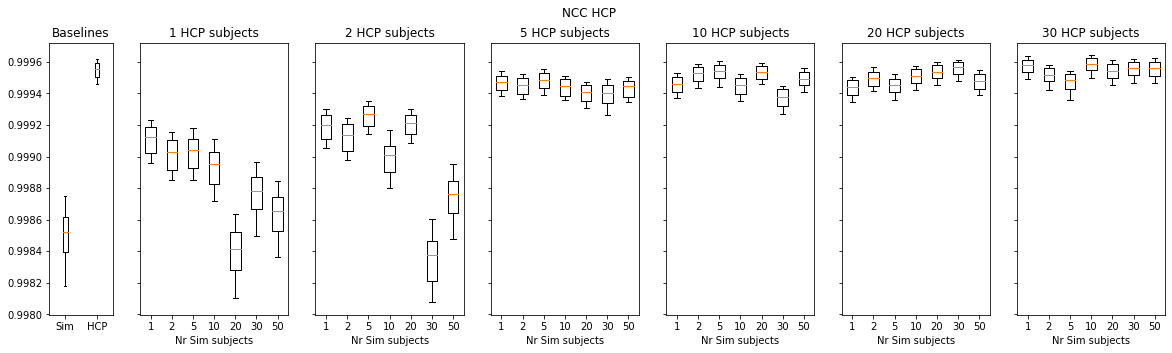

In [34]:
ncc_str1 = pd.read_csv('/mnt/beta/djboonstoppel/Code/output/baseline/hcp/ncc_df_baseline_hcp.csv', index_col=0, names=[30])
ncc_str2 = pd.read_csv('/mnt/beta/djboonstoppel/Code/output/baseline/hcp/ncc_df_baseline_sim.csv', index_col=0, names=[0])
baseline_hcp = [float(x) for x in (ncc_str1[30][0].strip('[]')).split(", ")]
baseline_sim = [float(x) for x in (ncc_str2[0][50].strip('[]')).split(", ")]
baselines = [baseline_sim, baseline_hcp]

ncc_str = pd.read_csv('/mnt/beta/djboonstoppel/Code/output/sweep-2/hcp/ncc_df.csv', index_col=0, names=[1,2,5,10,20,30])
nr_hcp_train = [1,2,5,10,20,30]
nr_sim_train = [1,2,5,10,20,30,50]
ncc = pd.DataFrame(columns = nr_hcp_train, index = nr_sim_train)
for nr_hcp in nr_hcp_train:
    for nr_sim in nr_sim_train:
        ncc[nr_hcp][nr_sim] = convert(ncc_str, nr_hcp, nr_sim)

# fig, ax = plt.subplots(nrows=1, ncols=len(nr_sim_train), figsize=[20,5], sharex=True, sharey=True)
# fig.set_facecolor('white')
# fig.suptitle('NCC HCP')
# for i in range(len(nr_sim_train)):
#     ax[i].boxplot(ncc.loc[nr_sim_train[i]], showfliers=False)
#     ax[i].set_title('{} Sim subjects'.format(nr_sim_train[i]))
#     ax[i].set_xlabel('Nr HCP subjects')
# ax[0].set_xticklabels(nr_hcp_train*len(nr_sim_train))
# fig.show()

fig, ax = plt.subplots(nrows=1, ncols=len(nr_hcp_train)+1, figsize=[20,5], sharey=True, gridspec_kw={'width_ratios': [3,7,7,7,7,7,7]})
fig.set_facecolor('white')
fig.suptitle('NCC HCP')
ax[0].boxplot(baselines, showfliers=False)
ax[0].set_title('Baselines')
ax[0].set_xticklabels(['Sim', 'HCP'])
for i in range(len(nr_hcp_train)):
    ax[i+1].boxplot(ncc[nr_hcp_train[i]], showfliers=False)
    ax[i+1].set_title('{} HCP subjects'.format(nr_hcp_train[i]))
    ax[i+1].set_xlabel('Nr Sim subjects')
    ax[i+1].set_xticklabels(nr_sim_train)
fig.show()
name = 'NCC'
fig.savefig(os.path.join('figs', name+'.png'), dpi=300, bbox_inches='tight')

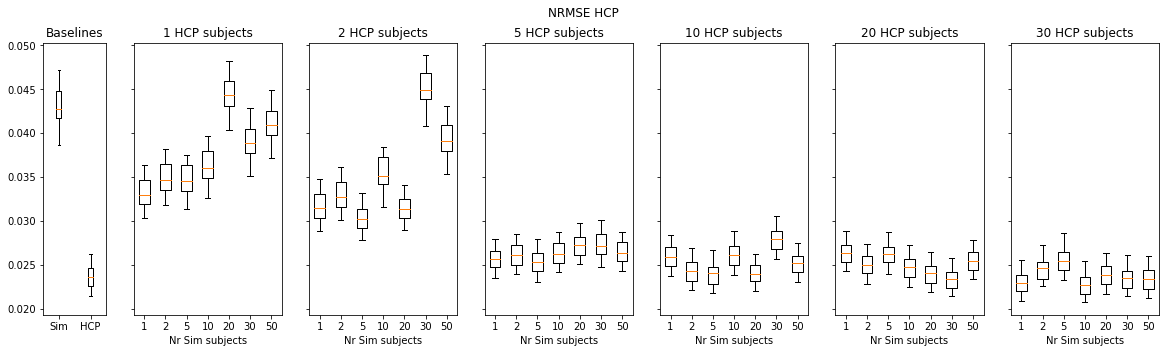

In [35]:
nrmse_str1 = pd.read_csv('/mnt/beta/djboonstoppel/Code/output/baseline/hcp/nrmse_df_baseline_hcp.csv', index_col=0, names=[30])
nrmse_str2 = pd.read_csv('/mnt/beta/djboonstoppel/Code/output/baseline/hcp/nrmse_df_baseline_sim.csv', index_col=0, names=[0])
baseline_hcp = [float(x) for x in (nrmse_str1[30][0].strip('[]')).split(", ")]
baseline_sim = [float(x) for x in (nrmse_str2[0][50].strip('[]')).split(", ")]
baselines = [baseline_sim, baseline_hcp]

nrmse_str = pd.read_csv('/mnt/beta/djboonstoppel/Code/output/sweep-2/hcp/nrmse_df.csv', index_col=0, names=[1,2,5,10,20,30])
nr_hcp_train = [1,2,5,10,20,30]
nr_sim_train = [1,2,5,10,20,30,50]
nrmse = pd.DataFrame(columns = nr_hcp_train, index = nr_sim_train)
for nr_hcp in nr_hcp_train:
    for nr_sim in nr_sim_train:
        nrmse[nr_hcp][nr_sim] = convert(nrmse_str, nr_hcp, nr_sim)

# fig, ax = plt.subplots(nrows=1, ncols=len(nr_sim_train), figsize=[20,5], sharex=True, sharey=True)
# fig.set_facecolor('white')
# fig.suptitle('nrmse HCP')
# for i in range(len(nr_sim_train)):
#     ax[i].boxplot(nrmse.loc[nr_sim_train[i]], showfliers=False)
#     ax[i].set_title('{} Sim subjects'.format(nr_sim_train[i]))
#     ax[i].set_xlabel('Nr HCP subjects')
# ax[0].set_xticklabels(nr_hcp_train*len(nr_sim_train))
# fig.show()

fig, ax = plt.subplots(nrows=1, ncols=len(nr_hcp_train)+1, figsize=[20,5], sharey=True, gridspec_kw={'width_ratios': [3,7,7,7,7,7,7]})
fig.set_facecolor('white')
fig.suptitle('NRMSE HCP')
ax[0].boxplot(baselines, showfliers=False)
ax[0].set_title('Baselines')
ax[0].set_xticklabels(['Sim', 'HCP'])
for i in range(len(nr_hcp_train)):
    ax[i+1].boxplot(nrmse[nr_hcp_train[i]], showfliers=False)
    ax[i+1].set_title('{} HCP subjects'.format(nr_hcp_train[i]))
    ax[i+1].set_xlabel('Nr Sim subjects')
    ax[i+1].set_xticklabels(nr_sim_train)
fig.show()
name = 'NRMSE'
fig.savefig(os.path.join('figs', name+'.png'), dpi=300, bbox_inches='tight')

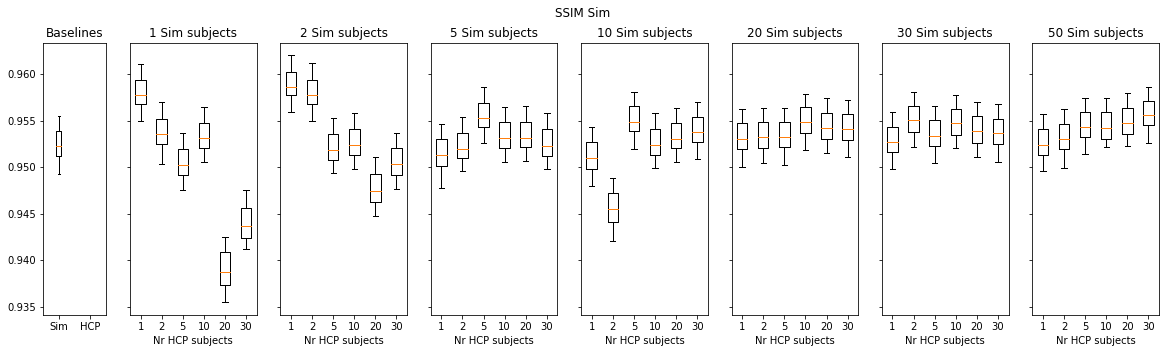

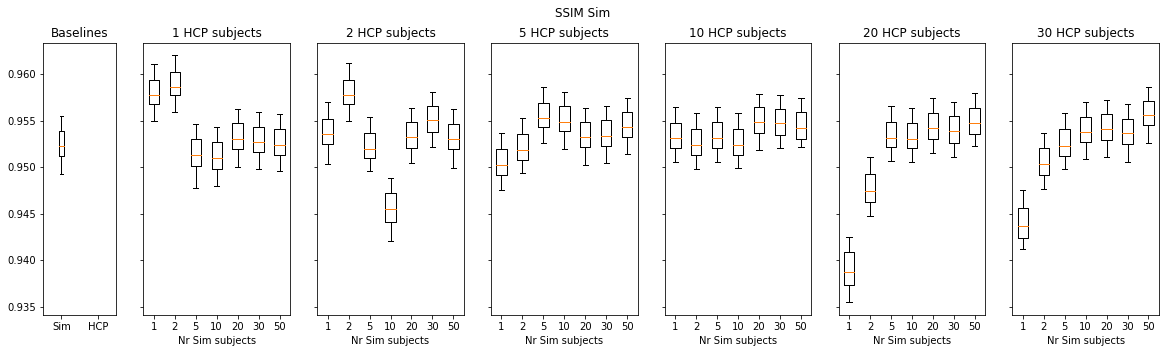

In [90]:
ssim_str1 = pd.read_csv('/mnt/beta/djboonstoppel/Code/output/baseline/sim/ssim_df_baseline_hcp.csv', index_col=0, names=[30])
ssim_str2 = pd.read_csv('/mnt/beta/djboonstoppel/Code/output/baseline/sim/ssim_df_baseline_sim.csv', index_col=0, names=[0])
baseline_hcp = [float(x) for x in (ssim_str1[30][0].strip('[]')).split(", ")]
baseline_sim = [float(x) for x in (ssim_str2[0][50].strip('[]')).split(", ")]
baselines = [baseline_sim, []]

ssim_str = pd.read_csv('/mnt/beta/djboonstoppel/Code/output/sweep-2/sim/ssim_df.csv', index_col=0, names=[1,2,5,10,20,30])
nr_hcp_train = [1,2,5,10,20,30]
nr_sim_train = [1,2,5,10,20,30,50]
ssim = pd.DataFrame(columns = nr_hcp_train, index = nr_sim_train)
for nr_hcp in nr_hcp_train:
    for nr_sim in nr_sim_train:
        ssim[nr_hcp][nr_sim] = convert(ssim_str, nr_hcp, nr_sim)

fig, ax = plt.subplots(nrows=1, ncols=len(nr_sim_train)+1, figsize=[20,5], sharey=True, gridspec_kw={'width_ratios': [3,6,6,6,6,6,6,6]})
fig.set_facecolor('white')
fig.suptitle('SSIM Sim')
ax[0].boxplot(baselines, showfliers=False)
ax[0].set_title('Baselines')
ax[0].set_xticklabels(['Sim', 'HCP'])
for i in range(len(nr_sim_train)):
    ax[i+1].boxplot(ssim.loc[nr_sim_train[i]], showfliers=False)
    ax[i+1].set_title('{} Sim subjects'.format(nr_sim_train[i]))
    ax[i+1].set_xlabel('Nr HCP subjects')
    ax[i+1].set_xticklabels(nr_hcp_train)
fig.show()

fig, ax = plt.subplots(nrows=1, ncols=len(nr_hcp_train)+1, figsize=[20,5], sharey=True, gridspec_kw={'width_ratios': [3.5,7,7,7,7,7,7]})
fig.set_facecolor('white')
fig.suptitle('SSIM Sim')
ax[0].boxplot(baselines, showfliers=False)
ax[0].set_title('Baselines')
ax[0].set_xticklabels(['Sim', 'HCP'])
for i in range(len(nr_hcp_train)):
    ax[i+1].boxplot(ssim[nr_hcp_train[i]], showfliers=False)
    ax[i+1].set_title('{} HCP subjects'.format(nr_hcp_train[i]))
    ax[i+1].set_xlabel('Nr Sim subjects')
    ax[i+1].set_xticklabels(nr_sim_train)
fig.show()

In [ ]:
ncc_str = pd.read_csv('/mnt/beta/djboonstoppel/Code/output/sweep-2/sim/ncc_df.csv', index_col=0, names=[1,2,5,10,20,30])
nr_hcp_train = [1,2,5,10,20,30]
nr_sim_train = [1,2,5,10,20,30,50]
ncc = pd.DataFrame(columns = nr_hcp_train, index = nr_sim_train)
for nr_hcp in nr_hcp_train:
    for nr_sim in nr_sim_train:
        ncc[nr_hcp][nr_sim] = convert(ncc_str, nr_hcp, nr_sim)

fig, ax = plt.subplots(nrows=1, ncols=len(nr_sim_train), figsize=[20,5], sharex=True, sharey=True)
fig.set_facecolor('white')
fig.suptitle('NCC Sim')
for i in range(len(nr_sim_train)):
    ax[i].boxplot(ncc.loc[nr_sim_train[i]], showfliers=False)
    ax[i].set_title('{} Sim subjects'.format(nr_sim_train[i]))
    ax[i].set_xlabel('Nr HCP subjects')
ax[0].set_xticklabels(nr_hcp_train*len(nr_sim_train))
fig.show()

fig, ax = plt.subplots(nrows=1, ncols=len(nr_hcp_train), figsize=[20,5], sharex=True, sharey=True)
fig.set_facecolor('white')
fig.suptitle('NCC Sim')
for i in range(len(nr_hcp_train)):
    ax[i].boxplot(ncc[nr_hcp_train[i]], showfliers=False)
    ax[i].set_title('{} HCP subjects'.format(nr_hcp_train[i]))
    ax[i].set_xlabel('Nr Sim subjects')
ax[0].set_xticklabels(nr_sim_train*len(nr_hcp_train))
fig.show()

In [ ]:
nrmse_str = pd.read_csv('/mnt/beta/djboonstoppel/Code/output/sweep-2/sim/nrmse_df.csv', index_col=0, names=[1,2,5,10,20,30])
nr_hcp_train = [1,2,5,10,20,30]
nr_sim_train = [1,2,5,10,20,30,50]
nrmse = pd.DataFrame(columns = nr_hcp_train, index = nr_sim_train)
for nr_hcp in nr_hcp_train:
    for nr_sim in nr_sim_train:
        nrmse[nr_hcp][nr_sim] = convert(nrmse_str, nr_hcp, nr_sim)

fig, ax = plt.subplots(nrows=1, ncols=len(nr_sim_train), figsize=[20,5], sharex=True, sharey=True)
fig.set_facecolor('white')
fig.suptitle('NRMSE Sim')
for i in range(len(nr_sim_train)):
    ax[i].boxplot(nrmse.loc[nr_sim_train[i]], showfliers=False)
    ax[i].set_title('{} Sim subjects'.format(nr_sim_train[i]))
    ax[i].set_xlabel('Nr HCP subjects')
ax[0].set_xticklabels(nr_hcp_train*len(nr_sim_train))
fig.show()

fig, ax = plt.subplots(nrows=1, ncols=len(nr_hcp_train), figsize=[20,5], sharex=True, sharey=True)
fig.set_facecolor('white')
fig.suptitle('NRMSE Sim')
for i in range(len(nr_hcp_train)):
    ax[i].boxplot(nrmse[nr_hcp_train[i]], showfliers=False)
    ax[i].set_title('{} HCP subjects'.format(nr_hcp_train[i]))
    ax[i].set_xlabel('Nr Sim subjects')
ax[0].set_xticklabels(nr_sim_train*len(nr_hcp_train))
fig.show()


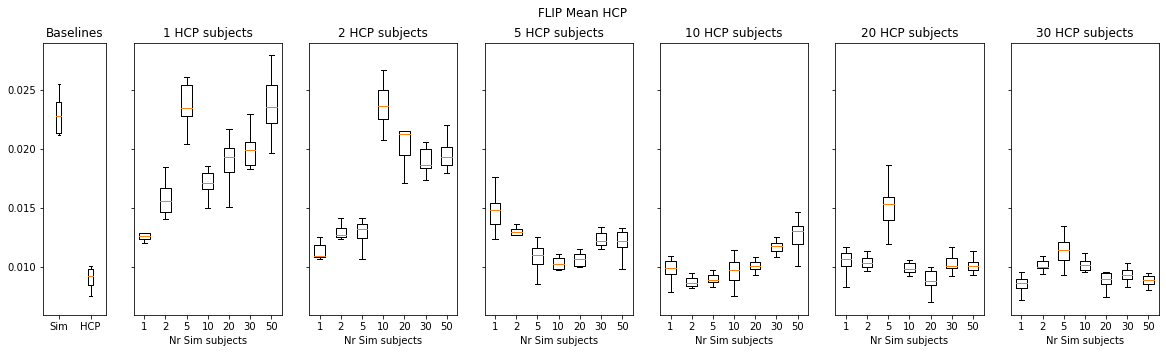

In [38]:
flip_mean_str1 = pd.read_csv('/mnt/beta/djboonstoppel/Code/output/baseline/hcp/flip_df_mean_baseline_hcp.csv', index_col=0, names=[30])
flip_mean_str2 = pd.read_csv('/mnt/beta/djboonstoppel/Code/output/baseline/hcp/flip_df_mean_baseline_sim.csv', index_col=0, names=[0])
baseline_hcp = [float(x) for x in (flip_mean_str1[30][0].strip('[]')).split(", ")]
baseline_sim = [float(x) for x in (flip_mean_str2[0][50].strip('[]')).split(", ")]
baselines = [baseline_sim, baseline_hcp]

flip_mean_str = pd.read_csv('/mnt/beta/djboonstoppel/Code/output/sweep-2/hcp/flip_mean.csv', index_col=0, names=[1,2,5,10,20,30])
nr_hcp_train = [1,2,5,10,20,30]
nr_sim_train = [1,2,5,10,20,30,50]
flip_mean = pd.DataFrame(columns = nr_hcp_train, index = nr_sim_train)
for nr_hcp in nr_hcp_train:
    for nr_sim in nr_sim_train:
        flip_mean[nr_hcp][nr_sim] = convert(flip_mean_str, nr_hcp, nr_sim)

# fig, ax = plt.subplots(nrows=1, ncols=len(nr_sim_train), figsize=[20,5], sharex=True, sharey=True)
# fig.set_facecolor('white')
# fig.suptitle('flip_mean HCP')
# for i in range(len(nr_sim_train)):
#     ax[i].boxplot(flip_mean.loc[nr_sim_train[i]], showfliers=False)
#     ax[i].set_title('{} Sim subjects'.format(nr_sim_train[i]))
#     ax[i].set_xlabel('Nr HCP subjects')
# ax[0].set_xticklabels(nr_hcp_train*len(nr_sim_train))
# fig.show()

fig, ax = plt.subplots(nrows=1, ncols=len(nr_hcp_train)+1, figsize=[20,5], sharey=True, gridspec_kw={'width_ratios': [3,7,7,7,7,7,7]})
fig.set_facecolor('white')
fig.suptitle('FLIP Mean HCP')
ax[0].boxplot(baselines, showfliers=False)
ax[0].set_title('Baselines')
ax[0].set_xticklabels(['Sim', 'HCP'])
for i in range(len(nr_hcp_train)):
    ax[i+1].boxplot(flip_mean[nr_hcp_train[i]], showfliers=False)
    ax[i+1].set_title('{} HCP subjects'.format(nr_hcp_train[i]))
    ax[i+1].set_xlabel('Nr Sim subjects')
    ax[i+1].set_xticklabels(nr_sim_train)
fig.show()
name = 'FLIP_mean'
fig.savefig(os.path.join('figs', name+'.png'), dpi=300, bbox_inches='tight')

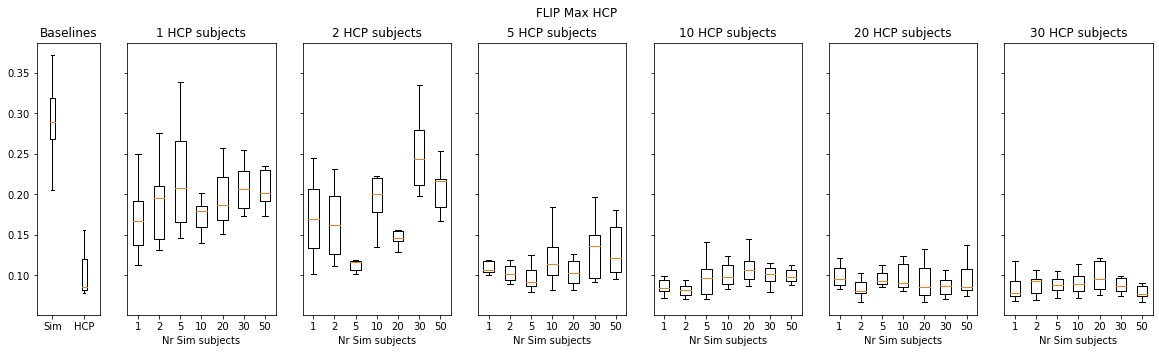

In [39]:
flip_max_str1 = pd.read_csv('/mnt/beta/djboonstoppel/Code/output/baseline/hcp/flip_df_max_baseline_hcp.csv', index_col=0, names=[30])
flip_max_str2 = pd.read_csv('/mnt/beta/djboonstoppel/Code/output/baseline/hcp/flip_df_max_baseline_sim.csv', index_col=0, names=[0])
baseline_hcp = [float(x) for x in (flip_max_str1[30][0].strip('[]')).split(", ")]
baseline_sim = [float(x) for x in (flip_max_str2[0][50].strip('[]')).split(", ")]
baselines = [baseline_sim, baseline_hcp]

flip_max_str = pd.read_csv('/mnt/beta/djboonstoppel/Code/output/sweep-2/hcp/flip_max.csv', index_col=0, names=[1,2,5,10,20,30])
nr_hcp_train = [1,2,5,10,20,30]
nr_sim_train = [1,2,5,10,20,30,50]
flip_max = pd.DataFrame(columns = nr_hcp_train, index = nr_sim_train)
for nr_hcp in nr_hcp_train:
    for nr_sim in nr_sim_train:
        flip_max[nr_hcp][nr_sim] = convert(flip_max_str, nr_hcp, nr_sim)

# fig, ax = plt.subplots(nrows=1, ncols=len(nr_sim_train), figsize=[20,5], sharex=True, sharey=True)
# fig.set_facecolor('white')
# fig.suptitle('flip_max HCP')
# for i in range(len(nr_sim_train)):
#     ax[i].boxplot(flip_max.loc[nr_sim_train[i]], showfliers=False)
#     ax[i].set_title('{} Sim subjects'.format(nr_sim_train[i]))
#     ax[i].set_xlabel('Nr HCP subjects')
# ax[0].set_xticklabels(nr_hcp_train*len(nr_sim_train))
# fig.show()

fig, ax = plt.subplots(nrows=1, ncols=len(nr_hcp_train)+1, figsize=[20,5], sharey=True, gridspec_kw={'width_ratios': [3,7,7,7,7,7,7]})
fig.set_facecolor('white')
fig.suptitle('FLIP Max HCP')
ax[0].boxplot(baselines, showfliers=False)
ax[0].set_title('Baselines')
ax[0].set_xticklabels(['Sim', 'HCP'])
for i in range(len(nr_hcp_train)):
    ax[i+1].boxplot(flip_max[nr_hcp_train[i]], showfliers=False)
    ax[i+1].set_title('{} HCP subjects'.format(nr_hcp_train[i]))
    ax[i+1].set_xlabel('Nr Sim subjects')
    ax[i+1].set_xticklabels(nr_sim_train)
fig.show()
name = 'FLIP_max'
fig.savefig(os.path.join('figs', name+'.png'), dpi=300, bbox_inches='tight')

In [42]:
ssim_str = pd.read_csv('/mnt/beta/djboonstoppel/Code/output/losses-final/sim/ssim_df_LR.csv', index_col=0, names=[0])
psnr_str = pd.read_csv('/mnt/beta/djboonstoppel/Code/output/losses-final/sim/psnr_df_LR.csv', index_col=0, names=[0])
nrmse_str = pd.read_csv('/mnt/beta/djboonstoppel/Code/output/losses-final/sim/nrmse_df_LR.csv', index_col=0, names=[0])
dim0 = [0] # perceptual
dim1 = [0] # adversarial
ssim = pd.DataFrame(columns = dim0, index = dim1)
psnr = pd.DataFrame(columns = dim0, index = dim1)
nrmse = pd.DataFrame(columns = dim0, index = dim1)
for x in dim0:
    for y in dim1:
        ssim[x][y] = convert(ssim_str, x, y)
        psnr[x][y] = convert(psnr_str, x, y)
        nrmse[x][y] = convert(nrmse_str, x, y)

# fig, ax = plt.subplots(nrows=1, ncols=len(dim0), figsize=[10,5], sharey=True)#, gridspec_kw={'width_ratios': [3,7,7,7,7,7,7]})
# fig.set_facecolor('white')
# fig.suptitle('SSIM')
# for i in range(len(dim0)):
#     ax[i].boxplot(ssim[dim0[i]], showfliers=False)
#     ax[i].set_title('Lambda perceptual: {}'.format(dim0[i]))
#     ax[i].set_xlabel('Lambda adversarial')
#     ax[i].set_xticklabels(dim1)
# fig.show()

In [43]:
lambda_perceptual = 0
lambda_adversarial = 0
print(np.mean(ssim[lambda_perceptual][lambda_adversarial]))
print(np.std(ssim[lambda_perceptual][lambda_adversarial]))
print(np.mean(psnr[lambda_perceptual][lambda_adversarial]))
print(np.std(psnr[lambda_perceptual][lambda_adversarial]))
print(np.mean(nrmse[lambda_perceptual][lambda_adversarial]))
print(np.std(nrmse[lambda_perceptual][lambda_adversarial]))

0.9339526561383078
0.0029420538124850515
33.71221239071652
0.281798821292427
0.05566715116060341
0.0009532834594658215
